## I. Import packages

In [1]:
import os
import numpy as np

import keras
from keras.models import Model

import random
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import rasterfairy
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## II. Construct Resnet50 model and load weights into it

### II.I. Define hyperparameters

In [2]:
images_path = '101_ObjectCategories'
features_path = 'features_resnet50.npy'
num_images = 1000
res_folder = 'Results_resnet50'

### II.II. Define model

In [3]:
model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet',
                                       input_tensor=None, input_shape=(224,224,3), pooling=None, classes=1000)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## III. Extract avg_pool-feaures for images of 101_ObjectCategories using the Resne50 model pretrained on ImageNet

In [5]:
def get_image(path):
    img = Image.open(path)
    if img.mode != 'RGB':  img = img.convert('RGB')
    img = img.resize((224, 224), Image.ANTIALIAS)
    img = np.array(img.getdata(), np.uint8)
    img = img.reshape(224, 224, 3).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames
          if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

if num_images < len(images):  images = [images[i] for i in sorted(random.sample(range(len(images)), num_images))]
else:  num_images = len(images)

In [7]:
def get_features(model, images, features_path):
    if not os.path.exists(features_path):
        print("Keeping %d images to analyze" % len(images))
        print("")
        features = np.array([])
        for idx,image_path in enumerate(images):
            if idx%100 == 0:  print("Getting features for %d/%d %s" % (idx+1, len(images), image_path))
            image = get_image(image_path);
            feat = model.predict(image)[0]
            features = np.append(features, feat)
        
        features = features.reshape((-1, np.array(model.output_shape[1:]).prod()))
        np.save(features_path, features)
        print("")
        print('Saved features to disk at location: ', features_path, ' !!!')
        
    else:
        print('Loading features in memory from location: ', features_path, ' ... ... ...')
        features = np.load(features_path)
        print('Features successfully loaded !!!')
    
    return features

In [8]:
features = get_features(model, images, features_path)

('Loading features in memory from location: ', 'features_resnet50.npy', ' ... ... ...')
Features successfully loaded !!!


## IV. Convert the avg_pool-features into 300-length-vector using PCA and then apply tSNE to further reduce it to 2-dimensions

In [9]:
pca_features = PCA(n_components=300).fit_transform(features)

X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.007s...
[t-SNE] Computed neighbors for 1000 samples in 0.502s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.170207
[t-SNE] Computed conditional probabilities in 0.201s
[t-SNE] Iteration 50: error = 72.3954163, gradient norm = 0.2567770 (50 iterations in 0.921s)
[t-SNE] Iteration 100: error = 72.3244171, gradient norm = 0.2523113 (50 iterations in 0.844s)
[t-SNE] Iteration 150: error = 71.8200531, gradient norm = 0.2387752 (50 iterations in 0.785s)
[t-SNE] Iteration 200: error = 71.9472885, gradient norm = 0.2552273 (50 iterations in 0.801s)
[t-SNE] Iteration 250: error = 72.3093796, gradient norm = 0.2440410 (50 iterations in 0.804s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.309380
[t-SNE] Iteration 300: error = 1.3589187, gradient norm = 0.0019727 (50 iterations in 0.684s)
[t-SNE] Iteration 350: error = 1.2352372, gradient norm = 0.00058

## V. Visualise the tSNE

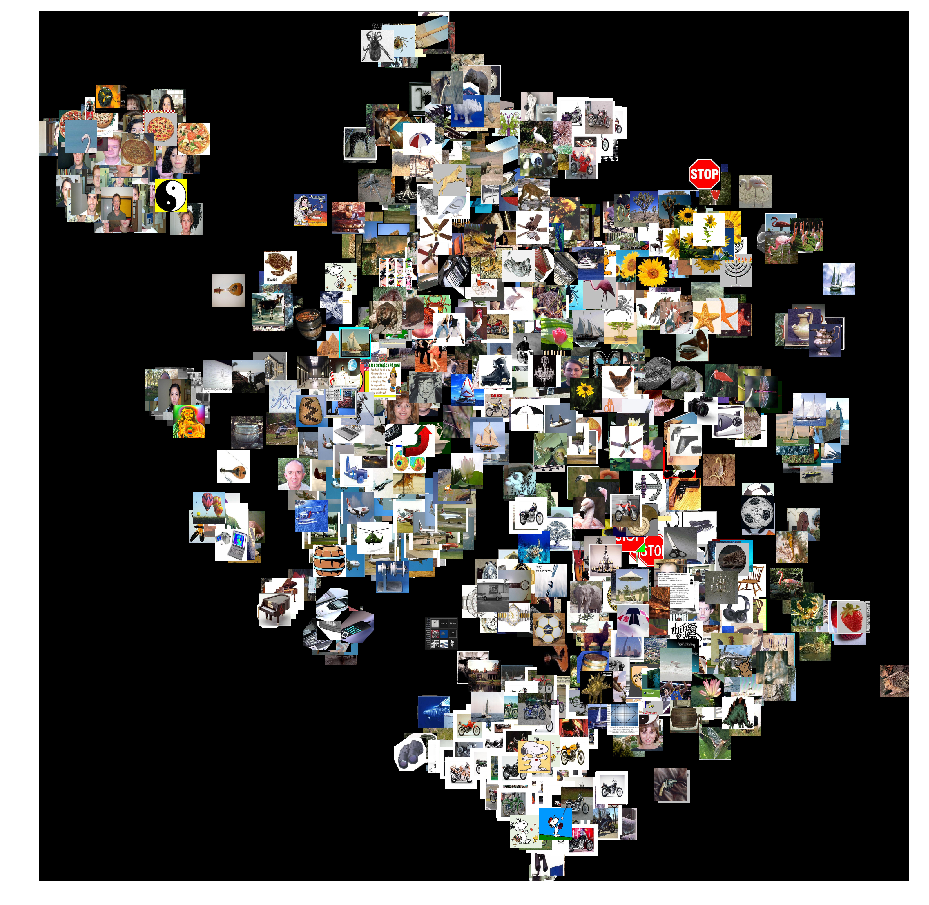

In [10]:
# Normalize tSNE points to [0,1]
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 3000
height = 3000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    tile_width = tile_height = 224
    rs = max(1, tile_width/max_dim, tile_height/max_dim)
    tile = tile.resize((int(tile_width/rs), int(tile_height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)))

plt.figure(figsize = (16,16))
imshow(full_image)
plt.axis('off')
plt.savefig(res_folder + '/myTSNE.png', bbox_inches='tight')
plt.show()

## VI. Place the images into grids for better visualisation

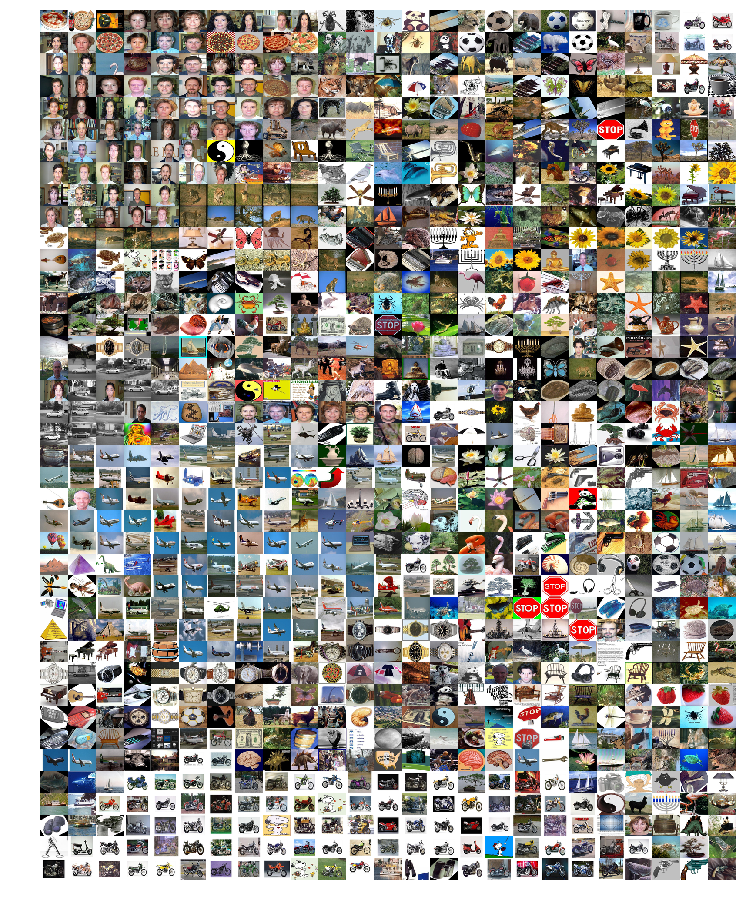

In [11]:
# nx * ny = number of images
nx = 25
ny = len(images)/nx

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

tile_width = 64
tile_height = 50

full_width = tile_width * nx
full_height = tile_height * ny

grid_image = Image.new('RGB', (full_width, full_height))
for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,16))
imshow(grid_image)
plt.axis('off')
plt.savefig(res_folder + '/myTSNEgrid.png', bbox_inches='tight')
plt.show()